## KMeans
### Kmeans clusters with the Elbow Method

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import squarify
import warnings
warnings.filterwarnings('ignore')


In [118]:
df_RFM = pd.read_csv('df_RFM.csv')

In [119]:
df = df_RFM[['Recency','Frequency','Monetary']]
df.head()

,Recency,Frequency,Monetary
0,91,21,361.45
1,26,19,345.10
2,4,21,334.15
3,3,24,316.81
4,142,15,312.46


In [120]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

sse

{1: 111667978.71493208,
 2: 39455852.3022563,
 3: 24266830.718370393,
 4: 19323283.695120882,
 5: 13796961.205798203,
 6: 12166656.581596589,
 7: 9912813.781841293,
 8: 8529392.524660083,
 9: 7611418.888219991,
 10: 6804636.462250587,
 11: 6190529.485145832,
 12: 5775860.457698934,
 13: 5327407.671476472,
 14: 4964269.929508292,
 15: 4651268.745433607,
 16: 4340818.100010535,
 17: 4024789.5150646623,
 18: 3875848.044465368,
 19: 3676281.7155400217}

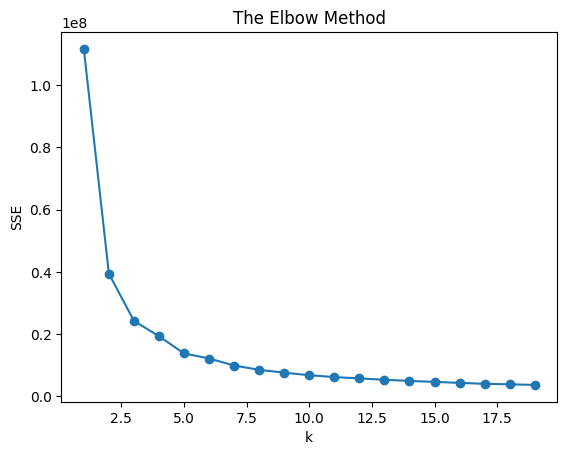

In [121]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.show()

In [122]:
# Build model with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df)
model.labels_.shape

(3898,)

In [123]:
df["Cluster"] = model.labels_
df.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        191.81      8.61    78.36  1076
1        560.38      4.27    37.16   300
2         63.63     14.83   175.41   603
3         55.30      8.69    71.32  1204
4        352.74      6.73    61.28   715

In [124]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,192.0,9.0,78.0,1076,27.60
1,Cluster 1,560.0,4.0,37.0,300,7.70
2,Cluster 2,64.0,15.0,175.0,603,15.47
3,Cluster 3,55.0,9.0,71.0,1204,30.89
4,Cluster 4,353.0,7.0,61.0,715,18.34


Kết quả phân cụm có 5 cụm như sau:

| Cụm | Số lượng | Đặc trưng tiềm năng |
|-----|----------|----------------------|
| 0   | 1076     | Phân khúc khách hàng chiếm tỷ lệ khá lớn (27.60%), có tần suất giao dịch trung bình (9.0), chi tiêu hoặc giá trị giao dịch trung bình (78.0), nhưng thời gian gần đây không hoạt động nhiều (192 ngày). Có thể là nhóm khách hàng trung thành nhưng không thường xuyên. |
| 1   | 300      | Phân khúc nhỏ nhất (7.70%), tần suất giao dịch thấp (4.0), chi tiêu hoặc giá trị giao dịch thấp (37.0), và đã lâu không hoạt động (560 ngày). Có thể là nhóm khách hàng không tích cực hoặc đã rời bỏ. |
| 2   | 603      | Phân khúc khách hàng trung bình (15.47%), tần suất giao dịch cao (15.0), chi tiêu hoặc giá trị giao dịch cao nhất (175.0), và hoạt động gần đây (64 ngày). Có thể là nhóm khách hàng cao cấp, thường xuyên và giá trị lớn. |
| 3   | 1204     | Phân khúc lớn nhất (30.89%), tần suất giao dịch trung bình (9.0), chi tiêu hoặc giá trị giao dịch trung bình (71.0), và hoạt động rất gần đây (55 ngày). Có thể là nhóm khách hàng phổ biến, ổn định và đang tích cực. |
| 4   | 715      | Phân khúc trung bình (18.34%), tần suất giao dịch trung bình (7.0), chi tiêu hoặc giá trị giao dịch trung bình (61.0), nhưng không hoạt động gần đây (353 ngày). Có thể là nhóm khách hàng tiềm năng nhưng đang giảm dần sự gắn kết. |

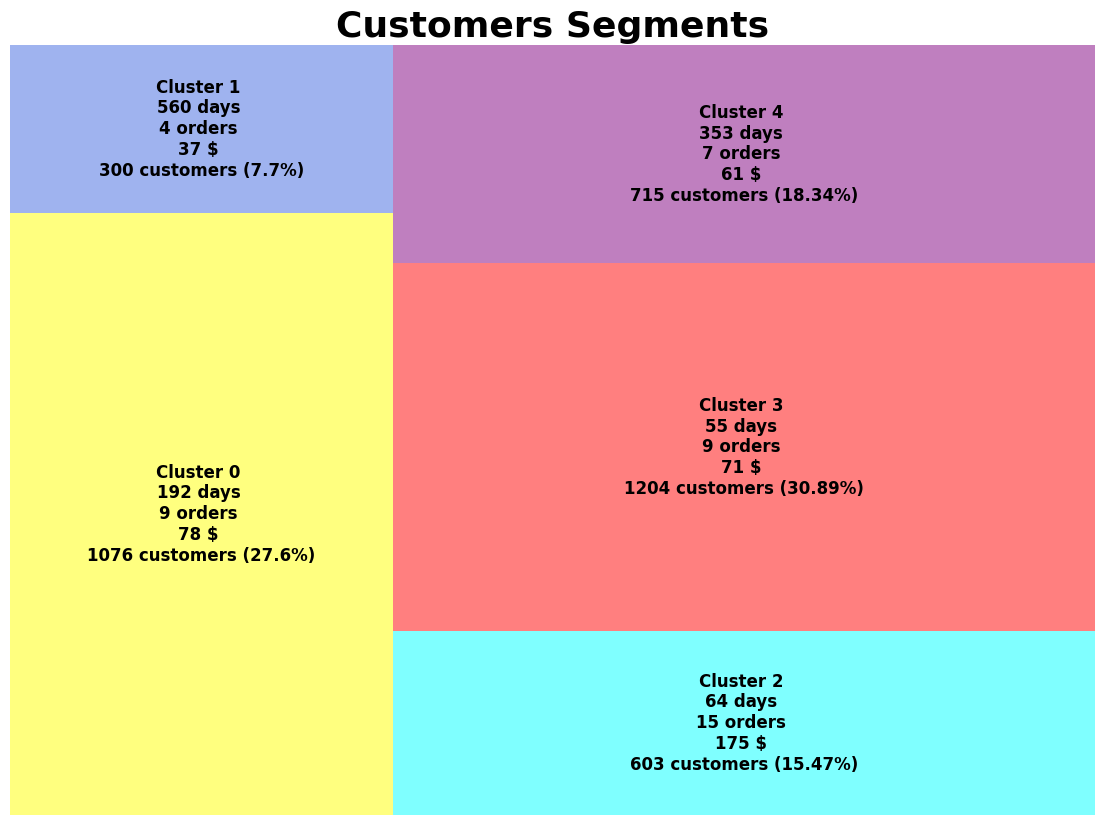

In [125]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('Kmeans Unsupervised Segments.png')
plt.show()

In [126]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()